In [1]:
%%capture
# IMPORTS
import GDI
import numpy as np
import itertools
from multiprocessing import Pool
from functools import partial
from IPython.utils import io
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# PLOT FONT SIZE
matplotlib.rcParams.update({'font.size': 20})

In [3]:
# PARAMETERS
# Note that sample_sizes corresponds to twice the number of samples
# used in GDI estimation, since sample_sizes defines the length of
# the time series while windows used in estimation consist of two 
# samples from the time series each
sample_sizes = np.asarray([500, 2000,5000,20000,100000])

# We add two to the dim_sizes, since by default one dim is used 
# for x and another is used for y. Anything >2 means that 
# conditioning on other time series is occurring, with each 
# additional dim corresponding to an additional time series
dim_sizes    = 2+np.asarray([0, 10, 20, 50, 100])
boot_iter    = 10
num_runs     = 50

# sim_type can be 'continuous' or 'discrete'
sim_type     = 'discrete'

# covariance for continuous case
rho = 0.6 

# for discrete case, p parameter for binary symmetric channel
p  = 0.1 
# prob of x spiking in a given time bin
Px = 0.3

In [4]:
# LOOP THROUGH SIMULATIONS
sample_sizes_list = [*range(sample_sizes.shape[0])]
dim_sizes_list = [*range(dim_sizes.shape[0])]
run_indice_list = np.arange(num_runs).tolist()

iter_list = list(itertools.product(sample_sizes_list, dim_sizes_list,run_indice_list))

In [5]:
# DEFINE FUNCTION FOR SCALING
def scaling_fun(sample_sizes,dim_sizes,boot_iter,sim_type,rho,p,Px,sim_conditions):
    # EXTRACT SIM CONDITIONS
    N = sample_sizes[sim_conditions[0]]
    dz = dim_sizes[sim_conditions[1]]
    print(N)
    # SIMULATE
    # DISCRETE
    if sim_type=='discrete':
        X = np.random.binomial(1,0.5,(N,dz))
        X[:,0] = np.random.binomial(1,Px,(N,))
        error_bit_stream = np.random.binomial(1,1-p,(N,))
        X[:,1] = (error_bit_stream*X[:,0])+((1-error_bit_stream)*(1-X[:,0]))
    
    # CONTINUOUS
    elif sim_type=='continuous':
        # COVARIANCE
        cov_mat = np.eye(dz)
        cov_mat[0,1] = rho
        cov_mat[1,0] = rho
        
        # GENERATE DATA
        X = np.random.multivariate_normal(np.zeros((dz,)), cov_mat, int(N))
    
    # UNSUPPORTED
    else:
        raise NameError('sim_type specified by user not supported')
    
    # SHIFT FOR CAUSALITY
    X[1:,1] = X[:-1,1]
    
    # REMOVE EXCESS SAMPLES AT END
    M = 1
    num_channels = X.shape[1]
    num_samples = X.shape[0]
    num_windows = int(np.floor(num_samples/(M+1)))
    num_samples_to_keep = int(num_windows*(M+1))
    X_trim = X[:num_samples_to_keep,:]

    # RESHAPE SO THAT MATRIX HAS DIM:
    #   (samples)x(X1(-M+i),X1(-M+1+i),...,X1(i),X2(-M+1),X2(-M+1+i),...)
    # WHERE EACH SAMPLE CORRESPONDS TO A WINDOW
    X_past_win = np.zeros((num_windows,num_channels*M))
    X_current  = np.zeros((num_windows,num_channels))
    for chan in range(num_channels):
        current_chan_mat = np.reshape(X_trim[:,chan],(num_windows,(M+1)))
        X_past_win[:,(chan*M):((chan+1)*M)] = current_chan_mat[:,:M]
        X_current[:,chan] = current_chan_mat[:,M]
    
    # ESTIMATE GDI
    GDI_est = GDI.pair_GDI(X_past_win,X_current,M,boot_iter,(0,1))
    
    # RETURN ESTIMATE
    return GDI_est

In [6]:
%%capture
# RUN ITERATIONS OF SCALING ANALYSIS IN PARALLEL
pool = Pool()
func = partial(scaling_fun,sample_sizes,dim_sizes,boot_iter,sim_type,rho,p,Px)
with io.capture_output() as captured:
    GDI_estimate_list = pool.map(func,iter_list)

In [7]:
# UNWRAP SCALING RESULTS
GDI_estimates_unwrapped = np.zeros((sample_sizes.shape[0],dim_sizes.shape[0],num_runs))
for ii in range(len(GDI_estimate_list)):
    GDI_estimates_unwrapped[iter_list[ii][0],iter_list[ii][1],iter_list[ii][2]] = GDI_estimate_list[ii]

In [8]:
# TRUE GDI
if sim_type=='continuous':
    true_GDI = -0.5*np.log(1-(rho**2))
elif sim_type=='discrete':
    # JOINT
    px1y1 = Px*(1-p)
    px1y0 = Px*p
    px0y1 = (1-Px)*p
    px0y0 = (1-Px)*(1-p)
    # MARGINAL
    py1 = px1y1+px0y1
    py0 = px1y0+px0y0
    px1 = px1y1+px1y0
    px0 = px0y1+px0y0
    # GDI
    true_GDI = (px1y1*np.log(px1y1/(px1*py1)))+(px1y0*np.log(px1y0/(px1*py0)))+(px0y1*np.log(px0y1/(px0*py1)))+(px0y0*np.log(px0y0/(px0*py0)))

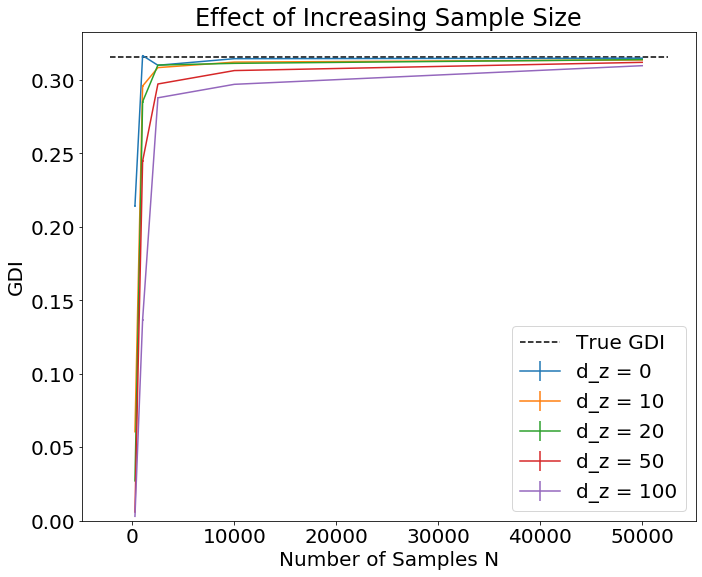

In [9]:
# NOTE THAT WE DIVIDE SAMPLE_SIZES BY 2 IN PLOTTING, 
# SINCE THIS REFERS TO THE ACTUAL NUMBER OF SAMPLES USED IN ESTIMATION
f, ax = plt.subplots(figsize=(11, 9))
for ii in range(dim_sizes.shape[0]):
    plt.errorbar(sample_sizes/2, np.mean(np.squeeze(GDI_estimates_unwrapped[:,ii,:]),axis=1), 
                 yerr=np.var(np.squeeze(GDI_estimates_unwrapped[:,ii,:]),axis=1), 
                 label='d_z = %i'%(dim_sizes[ii]-2))

plt.hlines(true_GDI,int(plt.xlim()[0]),int(plt.xlim()[1]),linestyles='dashed',label='True GDI')
plt.legend(loc='lower right')
plt.ylim((0,np.max(plt.ylim())))
plt.xlabel('Number of Samples N')
plt.ylabel('GDI')
plt.title('Effect of Increasing Sample Size');

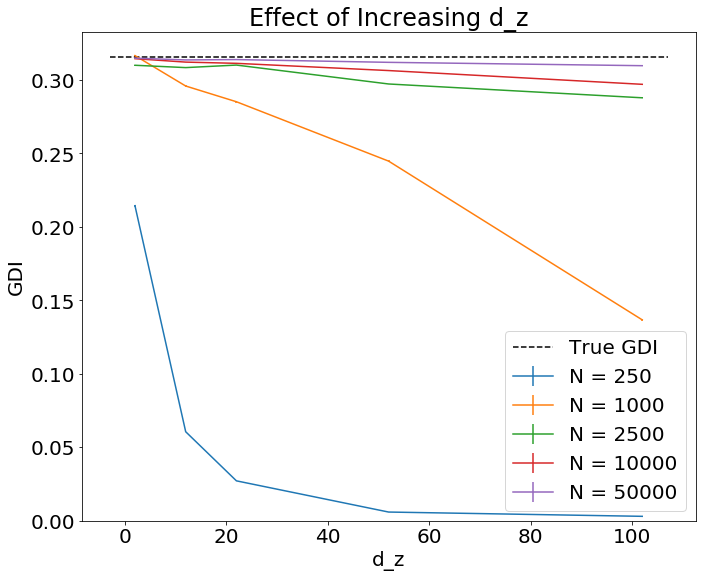

In [10]:
# NOTE THAT WE DIVIDE SAMPLE_SIZES BY 2 IN PLOTTING, 
# SINCE THIS REFERS TO THE ACTUAL NUMBER OF SAMPLES USED IN ESTIMATION
f, ax = plt.subplots(figsize=(11, 9))
for ii in range(sample_sizes.shape[0]):
    plt.errorbar(dim_sizes, np.mean(np.squeeze(GDI_estimates_unwrapped[ii,:,:]),axis=1), 
                 yerr=np.var(np.squeeze(GDI_estimates_unwrapped[ii,:,:]),axis=1), label='N = %i'%(sample_sizes[ii]/2))

plt.hlines(true_GDI,int(plt.xlim()[0]),int(plt.xlim()[1]),linestyles='dashed',label='True GDI')
plt.legend(loc='lower right')
plt.ylim((0,np.max(plt.ylim())))
plt.xlabel('d_z')
plt.ylabel('GDI')
plt.title('Effect of Increasing d_z');

In [11]:
# RESET SOME PARAMETERS FOR BOOTSTRAPPING ANALYSIS
sample_sizes = np.asarray([5000])
dim_sizes    = np.asarray([2])
boot_iter    = 50
num_runs     = 5

In [12]:
# REDEFINE FUNCTION FOR SCALING
def scaling_fun(sample_sizes,dim_sizes,boot_iter,sim_type,rho,p,Px,sim_conditions):
    # EXTRACT SIM CONDITIONS
    N = sample_sizes[sim_conditions[0]]
    dz = dim_sizes[sim_conditions[1]]
    print(N)
    # SIMULATE
    # DISCRETE
    if sim_type=='discrete':
        X = np.random.binomial(1,0.5,(N,dz))
        X[:,0] = np.random.binomial(1,Px,(N,))
        error_bit_stream = np.random.binomial(1,1-p,(N,))
        X[:,1] = (error_bit_stream*X[:,0])+((1-error_bit_stream)*(1-X[:,0]))
    
    # CONTINUOUS
    elif sim_type=='continuous':
        # COVARIANCE
        cov_mat = np.eye(dz)
        cov_mat[0,1] = rho
        cov_mat[1,0] = rho
        
        # GENERATE DATA
        X = np.random.multivariate_normal(np.zeros((dz,)), cov_mat, int(N))
    
    # UNSUPPORTED
    else:
        raise NameError('sim_type specified by user not supported')
    
    # SHIFT FOR CAUSALITY
    X[1:,1] = X[:-1,1]
    
    # REMOVE EXCESS SAMPLES AT END
    M = 1
    num_channels = X.shape[1]
    num_samples = X.shape[0]
    num_windows = int(np.floor(num_samples/(M+1)))
    num_samples_to_keep = int(num_windows*(M+1))
    X_trim = X[:num_samples_to_keep,:]

    # RESHAPE SO THAT MATRIX HAS DIM:
    #   (samples)x(X1(-M+i),X1(-M+1+i),...,X1(i),X2(-M+1),X2(-M+1+i),...)
    # WHERE EACH SAMPLE CORRESPONDS TO A WINDOW
    X_past_win = np.zeros((num_windows,num_channels*M))
    X_current  = np.zeros((num_windows,num_channels))
    for chan in range(num_channels):
        current_chan_mat = np.reshape(X_trim[:,chan],(num_windows,(M+1)))
        X_past_win[:,(chan*M):((chan+1)*M)] = current_chan_mat[:,:M]
        X_current[:,chan] = current_chan_mat[:,M]
    
    # ESTIMATE GDI
    GDI_est = np.zeros((boot_iter,))
    for ii in range(boot_iter):
        GDI_est[ii] = GDI.pair_GDI(X_past_win,X_current,M,1,(0,1))
    
    # RETURN ESTIMATE
    return GDI_est

In [13]:
%%capture
GDI_boot_analysis = np.zeros((num_runs,boot_iter))
sim_conditions = (0,0)
for ii in range(num_runs):
    GDI_boot_analysis[ii,:]=scaling_fun(sample_sizes,dim_sizes,boot_iter,sim_type,rho,p,Px,sim_conditions)

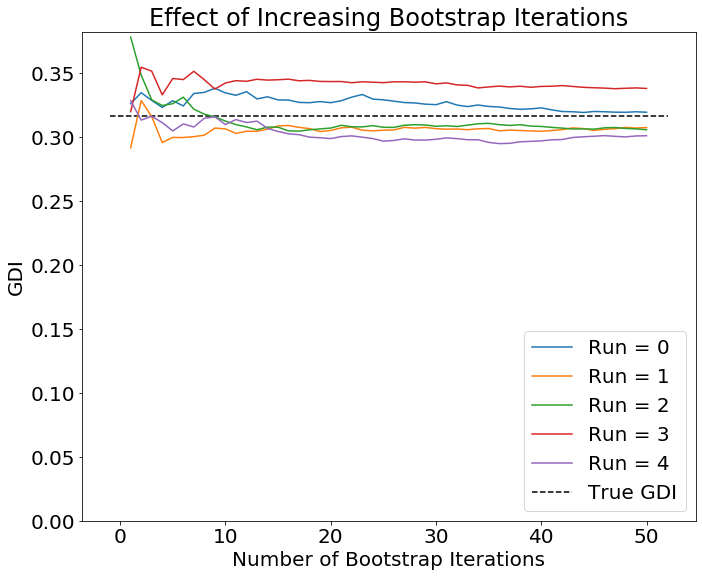

In [14]:
# PLOT ESTIMATE AS A FUNCTION OF BOOTSTRAP ITERATIONS
f, ax = plt.subplots(figsize=(11, 9))
for ii in range(num_runs):
    plt.plot(np.arange(boot_iter)+1, np.cumsum(GDI_boot_analysis[ii,:])/(np.arange(boot_iter)+1), 
               label='Run = %i'%ii)

plt.hlines(true_GDI,int(plt.xlim()[0]),int(plt.xlim()[1]),linestyles='dashed',label='True GDI')
plt.legend(loc='lower right')
plt.ylim((0,np.max(plt.ylim())))
plt.xlabel('Number of Bootstrap Iterations')
plt.ylabel('GDI')
plt.title('Effect of Increasing Bootstrap Iterations');